Here, we preprocess the [immune dictionary](https://doi.org/10.1038/s41586-023-06816-9) dataset as described in scPerturb in anticipation that datasets from scPerturb will also be used. rds files are downloaded from the Immune Dictionary [download](https://www.immune-dictionary.org/app/home) page.

In [135]:
import os

import scanpy as sc
import anndata as ad

import pandas as pd
import numpy as np
from scipy.stats import pearsonr

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings(action='ignore', module='pandas')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='ipykernel')
warnings.filterwarnings(action='ignore', category=FutureWarning, module='scanpy')
warnings.filterwarnings(action='ignore', category=UserWarning, module='scanpy')

import sys
sclembas_path = '/home/hmbaghda/Projects/scLEMBAS/scLEMBAS'
sys.path.insert(1, os.path.join(sclembas_path))
from preprocess import get_tf_activity

In [2]:
n_cores = 12
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

seed = 888
data_path = '/nobackup/users/hmbaghda/scLEMBAS/analysis'

In [3]:
quick_run = True # whether to subsample data and use quicker/less mem intensive (less accurate) versions of parameters

quick_dict = {'quick': {'perm': int(10), 'n_samples': int(1e3), 'batch_size': int(1e3)},
             'full': {'perm': int(1e3), 'n_samples': None, 'batch_size': int(1e4)}}
if quick_run: 
    run_key = 'quick'
else:
    run_key = 'full'

In [4]:
# grid search params
use_raw = False
# impute = True

In [5]:
directory_names = [
    #data_path,
    #os.path.join(data_path, 'raw'), os.path.join(data_path, 'raw', 'immune_dictionary'),
    os.path.join(data_path, 'interim'), os.path.join(data_path, 'interim', 'immune_dictionary_h5ad'),
    os.path.join(data_path, 'processed'), os.path.join(data_path, 'figures')
]

for directory_name in directory_names:
    if not os.path.exists(directory_name):
        os.makedirs(directory_name)


Load h5ad files:

In [15]:
h5ad_in_path = os.path.join(data_path, 'interim', 'immune_dictionary_h5ad')
file_names = os.listdir(h5ad_in_path)

imm_d = {}
for file_name in file_names:
    cell_type = file_name.split('ref_data_')[1].split('.h5ad')[0]
    adata = sc.read_h5ad(os.path.join(h5ad_in_path, file_name)) # Seurat counts slot in adata.raw.X, data slot in adata.X
    imm_d[cell_type] = adata
adata = ad.concat(list(imm_d.values()),  join="outer")

In [16]:
adata

AnnData object with n_obs × n_vars = 96034 × 31053
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'channel', 'nCount_HTO', 'nFeature_HTO', 'MULTI_ID', 'MULTI_classification', 'percent_mito', 'RNA_snn_res.1.5', 'seurat_clusters', 'cluster_manual', 'celltype', 'channel_hashtag', 'sample', 'rep'
    obsm: 'X_pca', 'X_tsne'

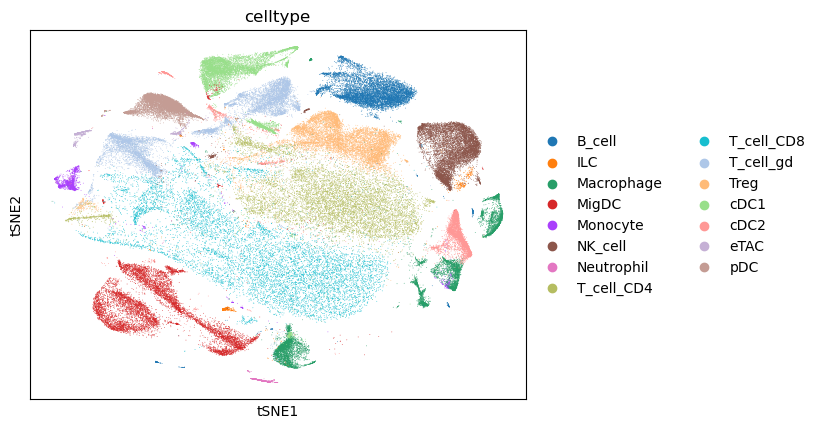

In [8]:
sc.pl.tsne(adata, color='celltype')

Get TF activity estimates:

In [10]:
if quick_run:
    adata = sc.pp.subsample(adata, n_obs = quick_dict[run_key]['n_samples'], copy = True, random_state = seed) 

kwargs = {'args' : {'wsum' : {'times': quick_dict[run_key]['perm'], 'batch_size': quick_dict[run_key]['batch_size']},
                       'ulm' : {'batch_size': quick_dict[run_key]['batch_size']}, 
                        'mlm': {'batch_size': quick_dict[run_key]['batch_size']}
                       }}
# kwargs['methods'] = ['lm', 'ulm', 'wsum', 
# kwargs['cns_metds'] = ['lm', 'ulm', 'wsum_norm']
get_tf_activity(adata, organism = 'mouse', grn = 'collectri', verbose = True, 
                min_n = 5, use_raw = use_raw, **kwargs)


# save
fn = 'ID_TF_activity_estimate_' + run_key + '.csv'
fn = os.path.join(data_path, 'interim', fn) 
adata.obsm['consensus_estimate'].to_csv(fn)
adata.obsm['consensus_pvals'].to_csv(fn.replace('_estimate_', '_pvals_'))

/nobackup/users/hmbaghda/Software/miniforge3/envs/scLEMBAS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Running consensus.
15760 features of mat are empty, they will be removed.
Running mlm on mat with 1000 samples and 15293 targets for 614 sources.


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.07s/it]


15760 features of mat are empty, they will be removed.
Running ulm on mat with 1000 samples and 15293 targets for 614 sources.


100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  3.09it/s]


15760 features of mat are empty, they will be removed.
Running wsum on mat with 1000 samples and 15293 targets for 614 sources.


100%|█████████████████████████████████████████████| 1/1 [00:02<00:00,  2.63s/it]


The immune dictionary identified cytokine-driven polarization states for each cell type. This is a good starting point to test whether scLEMBAS can capture the heterogeneity of single-cell responses. 

In the simplest case, we take one ligand and one polarization state. In other words, cells are exposed to just one ligand, and the perturbed response forms a single cluster/cell state. Let's start with the TNF driven macrophage subcluster, Mac-d (also labelled subcluster XXX)

<font color='red'>Since this information is not currently publically available, we just choose a ligand that minimizes Pielou’s Evenness Index (normalized Shannon entropy) -- IL 15</font>

<font color='red'>If continue with this, need to double check the code below is correct. It was generated by ChatGPT</font>

In [152]:
def entropy(row):
    proportions = row / row.sum()
    entropy = -np.sum(proportions * np.log(proportions))
    return entropy

def max_entropy(n_categories):
    if n_categories <= 1:
        return 0
    return np.log(n_categories)
    
def shannon_evenness(df, sample_col, cluster_col):
    entropy_df = df.groupby([sample_col, cluster_col]).size().unstack(fill_value=0)
    entropy_values = entropy_df.apply(entropy, axis=1)
    max_entropy_values = entropy_df.apply(lambda x: max_entropy(len(x)), axis=1)
    evenness = entropy_values / max_entropy_values
    return evenness.replace([np.inf, -np.inf], np.nan)

def diversity(row):
    proportions = row / row.sum()
    return 1 - np.sum(proportions**2)

def simpson_diversity(df, sample_col, cluster_col):    
    diversity_df = df.groupby([sample_col, cluster_col]).size().unstack(fill_value=0)
    diversity_values = diversity_df.apply(diversity, axis=1)
    return diversity_values

In [153]:
purity = pd.concat([shannon_evenness(adata_mac.obs, 'sample', 'seurat_clusters'), 
           simpson_diversity(adata_mac.obs, 'sample', 'seurat_clusters')], axis = 1)
purity.columns = ['pielou_evenness', 'simpson_diversity']

best_ligand = pd.concat([purity.min(), purity.idxmin()], axis = 1)
best_ligand.columns = ['score', 'ligand_ID']
best_ligand

/tmp/ipykernel_1991116/1183060850.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  entropy_df = df.groupby([sample_col, cluster_col]).size().unstack(fill_value=0)
/tmp/ipykernel_1991116/1183060850.py:23: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diversity_df = df.groupby([sample_col, cluster_col]).size().unstack(fill_value=0)


,score,ligand_ID
pielou_evenness,0.657402,Adiponectin
simpson_diversity,0.540200,Adiponectin


Text(0.1, 0.9, 'Pearson r: 0.952')

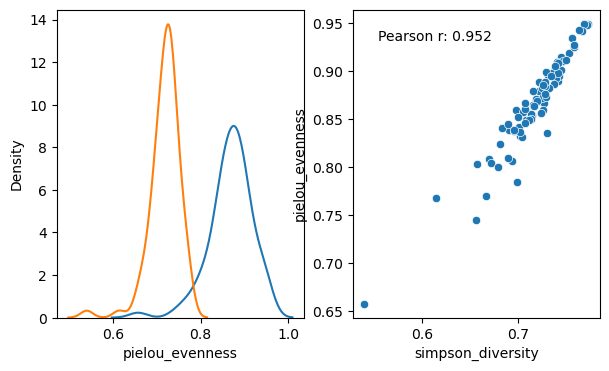

In [137]:
fig, ax = plt.subplots(figsize = (7,4), ncols = 2)
sns.kdeplot(purity.pielou_evenness, ax = ax[0])
sns.kdeplot(purity.simpson_diversity, ax = ax[0])
sns.scatterplot(data = purity, x = 'simpson_diversity', y = 'pielou_evenness', ax = ax[1])
pr = pearsonr(purity.pielou_evenness, purity.simpson_diversity).statistic
ax[1].annotate('Pearson r: {:.3f}'.format(pr), xy = (0.1, 0.9), xycoords='axes fraction')


In [164]:
lid = 'Adiponectin'
ligand_counts = pd.concat([adata_mac.obs[adata_mac.obs['sample'] == lid]['seurat_clusters'].value_counts(),
                           adata_mac.obs[adata_mac.obs['sample'] == 'PBS']['seurat_clusters'].value_counts()], axis = 1)
ligand_counts.columns = [lid, 'PBS']
ligand_counts

,Adiponectin,PBS
seurat_clusters,,
21,64,32
14,20,40
24,7,17
31,7,4
36,2,7


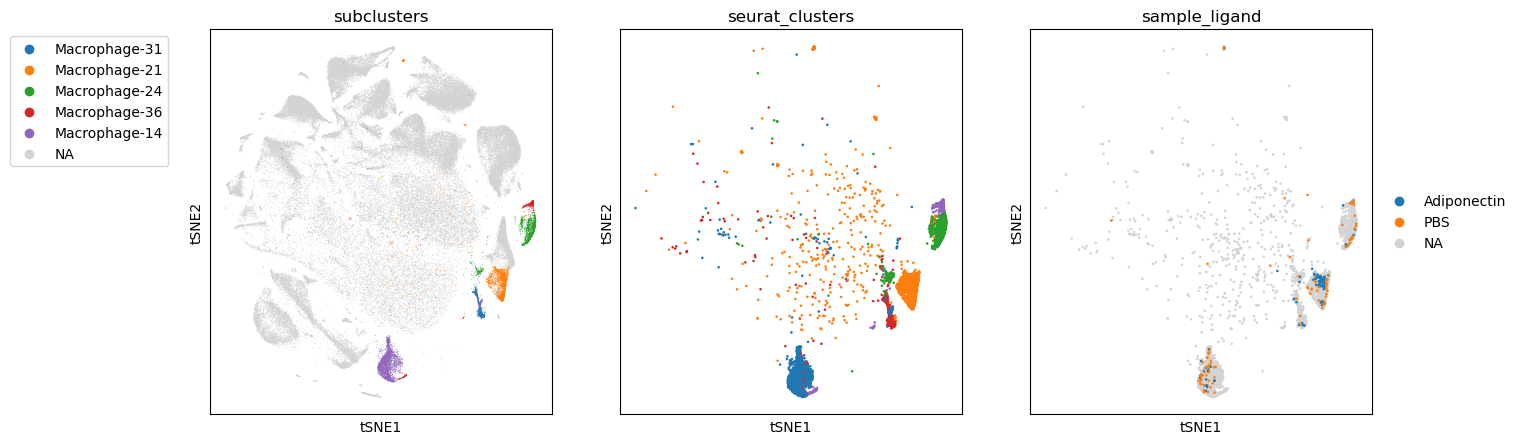

<Figure size 640x480 with 0 Axes>

In [181]:
adata.obs['subclusters'] = adata.obs.celltype.str.cat(adata.obs.seurat_clusters.astype(str), sep = '-')
macrophage_subclusters = [sc for sc in adata.obs.subclusters.unique() if sc.startswith('Macrophage')]
adata.obs.subclusters = pd.Categorical(adata.obs.subclusters, 
                      categories=macrophage_subclusters,
                      ordered=False)

adata_mac.obs['sample_ligand'] = adata_mac.obs['sample'].copy()
macrophage_ligands = [lid, 'PBS']
adata_mac.obs['sample_ligand'] = pd.Categorical(adata_mac.obs['sample_ligand'],
                                                categories=macrophage_ligands,
                                                ordered=False)


fig, ax = plt.subplots(ncols = 3, figsize = (15, 5))
sc.pl.tsne(adata, color='subclusters', ax = ax[0], show = False)
ax[0].legend(bbox_to_anchor=(-0.1, 1), bbox_transform=ax[0].transAxes)
sc.pl.tsne(adata_mac, color='seurat_clusters', ax = ax[1], show = False)
ax[1].legend().set_visible(False)
sc.pl.tsne(adata_mac, color='sample_ligand', ax = ax[2])
ax[2].legend(bbox_to_anchor=(0.1, 1), bbox_transform=ax[2].transAxes)
plt.tight_layout()

Adiponectin is very strongly in cluster 21, and PBS is present in cluster 14. So, for now, we will make this a simple 1-to-1 mapping: only cluster 21 cells from the adiponectin stimulation and cluster 14 cells from the PBS stimulation will be kept as input to the model. 

In [189]:
adata_in = adata[(adata.obs['celltype'] == 'Macrophage') & \
                 (((adata.obs['sample'] == lid) & (adata.obs['seurat_clusters'] == 21)) | \
                  ((adata.obs['sample'] == 'PBS') & (adata.obs['seurat_clusters'] == 14))
                 )]